In [61]:
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import SVG
import os
from keras.models import load_model

In [62]:
total_data = pd.read_csv('features.csv', index_col=0)

In [63]:
total_data = total_data[total_data['image_time'] <= 60000]
total_data = total_data[total_data['human_len'] <= 40]

In [64]:
features = total_data[['prob', 'human_len', 'ai_len', 'image_time', 'similarity']]
labels = total_data[['correct']]

In [65]:
def visual_hist(features, columns=None, figsize=(12,6)):
    if columns is None:
        columns = features.columns
    
    fig, ax = plt.subplots(2, math.ceil(len(columns)/2), figsize=figsize)
    
    for i, col in enumerate(columns):
        if i % 2 == 0:
            try:
                ax[0][int(i/2)].hist(features[col], bins=40)
                ax[0][int(i/2)].set_title(col)
            except:
                ax[0].hist(features[col], bins=40)
                ax[0].set_title(col)
        else:
            try:
                ax[1][int(i/2)].hist(features[col], bins=40)
                ax[1][int(i/2)].set_title(col)
            except:
                ax[1].hist(features[col], bins=40)
                ax[1].set_title(col)

    plt.show()

In [66]:
def scaler_stand(train, test, columns=None):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.fit_transform(test)

    if columns is None:
        train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.columns)
    else :
        train_scaled = pd.DataFrame(train_scaled, columns=columns)
        test_scaled = pd.DataFrame(test_scaled, columns=columns)

    return train_scaled, test_scaled

In [67]:
def scaler_robust(train, test, columns=None):
    robustScaler = RobustScaler()
    train_scaled = robustScaler.fit_transform(train)
    test_scaled = robustScaler.fit_transform(test)

    if columns is None:
        train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.columns)

    else :
        train_scaled = pd.DataFrame(train_scaled, columns=columns)
        test_scaled = pd.DataFrame(test_scaled, columns=columns)
    
    return train_scaled, test_scaled

In [68]:
def visual_model_performance(loss_and_accuracy, pred_and_label):
    print ("Test Accuracy = " + str(loss_and_accuracy[1]))

    sns.scatterplot(data=pred_and_label, x='index', y='prob', hue='correct')

In [69]:
def visual_training(hist):
    fig, loss_ax = plt.subplots(1,2, figsize=(12,5))

    loss_ax[0].set_title("model loss")
    loss_ax[1].set_title("model accuracy")

    loss_ax[0].plot(hist.history['loss'], 'y', label='train loss')
    loss_ax[0].plot(hist.history['val_loss'], 'r', label='val loss')
    try:
        loss_ax[1].plot(hist.history['accuracy'], 'b', label='train accuracy')
        loss_ax[1].plot(hist.history['val_accuracy'], 'g', label='val accuracy')
    except:
        loss_ax[1].plot(hist.history['acc'], 'b', label='train accuracy')
        loss_ax[1].plot(hist.history['val_acc'], 'g', label='val accuracy')


    loss_ax[0].set_xlabel('epoch')
    loss_ax[1].set_xlabel('epoch')

    loss_ax[0].set_ylabel('loss')
    loss_ax[1].set_ylabel('accuray')

    loss_ax[0].legend(loc='upper left')
    loss_ax[1].legend(loc='upper left')

    plt.show()

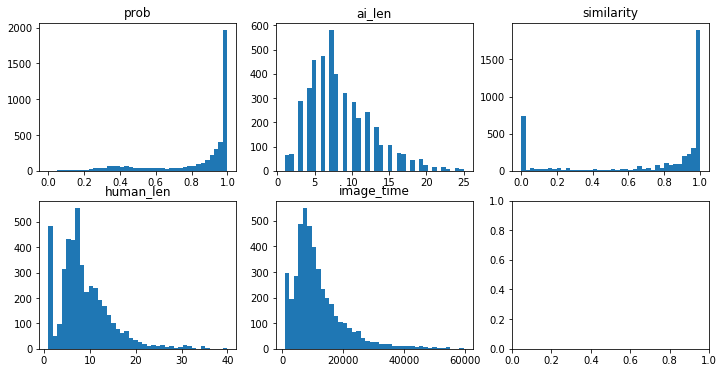

In [70]:
visual_hist(features)

In [71]:
# separate train and dev, val set
x_train, x_dev, y_train, y_dev = train_test_split(features, labels, test_size = 0.3)
x_dev, x_val, y_dev, y_val = train_test_split(x_dev, y_dev, test_size = 0.25)

In [72]:
print(len(x_train), len(x_dev), len(x_val))

3119 1003 335


In [ ]:
model = Sequential()
model.add(Dense(5, input_shape=(5,)))
model.add(Activation('tanh'))
model.add(Dense(25))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 아키텍처 확인
# model.summary()

# stardard
robustScaler = RobustScaler()
std_train = robustScaler.fit_transform(x_train)
std_dev = robustScaler.transform(x_dev)
std_val = robustScaler.transform(x_val)

# tesor board 
tb_hist = TensorBoard(log_dir='./log/new_model', histogram_freq=0, write_graph=True, write_images=True)

# Training
hist = model.fit(std_train, y_train, epochs=1500, batch_size=128,\
                 validation_data=(std_dev, y_dev), verbose=0, \
                 callbacks=[tb_hist], use_multiprocessing=True)

# test
loss_and_accuracy = model.evaluate(x=std_val, y=y_val)

# save
if loss_and_accuracy[1] >= 0.94:
    model.save('feature5_dropout_94_1.h5')
    print("over 0.94")

y_pred = model.predict(std_val) 
pred_and_label = pd.DataFrame({'index':range(len(y_val)),'prob':y_pred.T[0], 'correct':y_val.correct})

In [ ]:
visual_training(hist)
visual_model_performance(loss_and_accuracy, pred_and_label)

In [93]:
model = Sequential()
model.add(Dense(25, input_shape=(5,)))
model.add(Activation('tanh'))
model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(8))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 아키텍처 확인
# model.summary()

# stardard
robustScaler = RobustScaler()
std_train = robustScaler.fit_transform(x_train)
std_dev = robustScaler.transform(x_dev)
std_val = robustScaler.transform(x_val)

# tesor board 
tb_hist = TensorBoard(log_dir='./log/new_model', histogram_freq=0, write_graph=True, write_images=True)

# Training
hist = model.fit(std_train, y_train, epochs=1000, batch_size=128,\
                 validation_data=(std_dev, y_dev), verbose=0, \
                 callbacks=[tb_hist], use_multiprocessing=True)

# test
loss_and_accuracy = model.evaluate(x=std_val, y=y_val)

# save
if loss_and_accuracy[1] >= 0.94:
    model.save('feature5_dropout_94_2.h5')
    print("over 0.94")

y_pred = model.predict(std_val)
pred_and_label = pd.DataFrame({'index':range(len(y_val)),'prob':y_pred.T[0], 'correct':y_val.correct})

335/335 [==============================] - 0s 77us/step


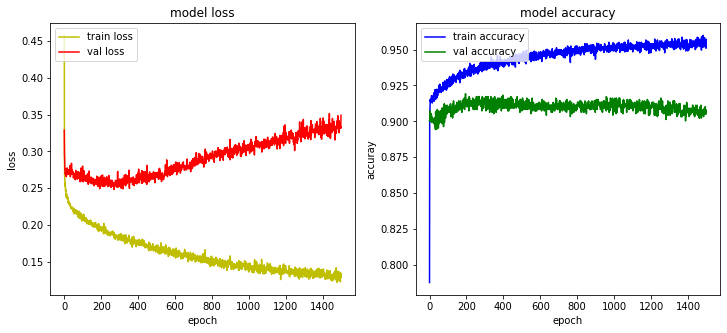

Test Accuracy = 0.9104477763175964


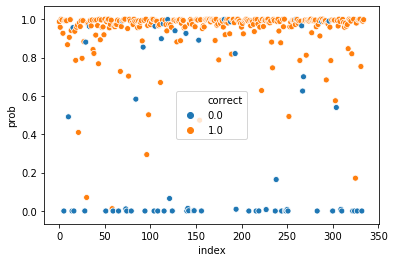

In [94]:
visual_training(hist)
visual_model_performance(loss_and_accuracy, pred_and_label)

In [91]:
model = Sequential()
model.add(Dense(25, input_shape=(5,)))
model.add(Activation('tanh'))
model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 아키텍처 확인
# model.summary()

# stardard
robustScaler = RobustScaler()
std_train = robustScaler.fit_transform(x_train)
std_dev = robustScaler.transform(x_dev)
std_val = robustScaler.transform(x_val)

# tesor board 
tb_hist = TensorBoard(log_dir='./log/new_model', histogram_freq=0, write_graph=True, write_images=True)

# Training
hist = model.fit(std_train, y_train, epochs=1500, batch_size=128,\
                 validation_data=(std_dev, y_dev), verbose=0, \
                 callbacks=[tb_hist], use_multiprocessing=True)

# test
loss_and_accuracy = model.evaluate(x=std_val, y=y_val)

# save
if loss_and_accuracy[1] >= 0.94:
    model.save('feature5_dropout_94_3.h5')
    print("over 0.94")

y_pred = model.predict(std_val)
pred_and_label = pd.DataFrame({'index':range(len(y_val)),'prob':y_pred.T[0], 'correct':y_val.correct})

335/335 [==============================] - 0s 77us/step


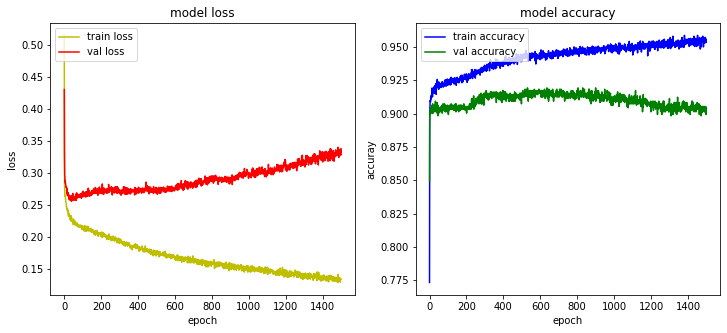

Test Accuracy = 0.9134328365325928


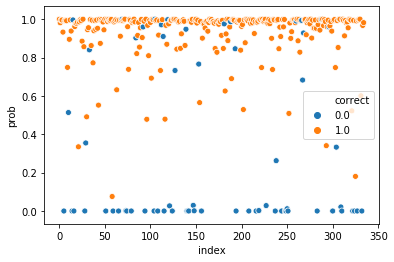

In [92]:
visual_training(hist)
visual_model_performance(loss_and_accuracy, pred_and_label)

In [89]:
model = Sequential([
    Dense(25, input_shape=(5,)),
    Activation('tanh'),
    Dense(64),
    Activation('tanh'),
    Dense(16),
    Activation('tanh'),
    Dense(1),
    Activation('sigmoid'),
])

# 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 아키텍처 확인
# model.summary()

# separate train and test


# stardard
robustScaler = RobustScaler()
std_train = robustScaler.fit_transform(x_train)
std_dev = robustScaler.transform(x_dev)
std_val = robustScaler.transform(x_val)

# tesor board 
tb_hist = TensorBoard(log_dir='./log/new_model', histogram_freq=0, write_graph=True, write_images=True)

# Training
hist = model.fit(std_train, y_train, epochs=1500, batch_size=128,\
                 validation_data=(std_dev, y_dev), verbose=0, \
                 callbacks=[tb_hist], use_multiprocessing=True)

# test
loss_and_accuracy = model.evaluate(x=std_val, y=y_val)

# save
if loss_and_accuracy[1] >= 0.94:
    model.save('feature5_dropout_94_4.h5')
    print("over 0.94")


y_pred = model.predict(std_val)
pred_and_label = pd.DataFrame({'index':range(len(y_val)),'prob':y_pred.T[0], 'correct':y_val.correct})

335/335 [==============================] - 0s 54us/step


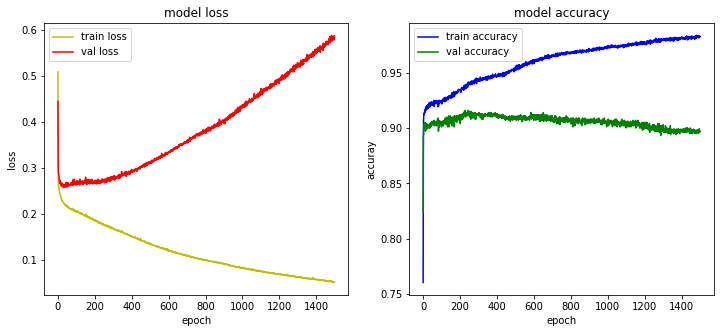

Test Accuracy = 0.89552241563797


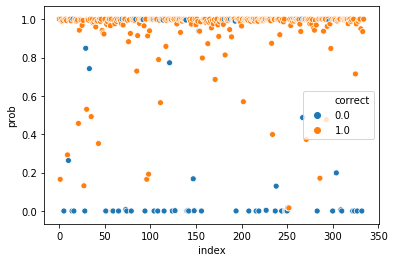

In [90]:
visual_training(hist)
visual_model_performance(loss_and_accuracy, pred_and_label)

In [87]:
model = Sequential([
    Dense(25, input_shape=(5,)),
    Activation('tanh'),
    Dense(64),
    Activation('tanh'),
    Dropout(0.2),
    Dense(16),
    Activation('tanh'),
    Dense(1),
    Activation('sigmoid'),
])

# 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 아키텍처 확인
# model.summary()

# separate train and test


# stardard
robustScaler = RobustScaler()
std_train = robustScaler.fit_transform(x_train)
std_dev = robustScaler.transform(x_dev)
std_val = robustScaler.transform(x_val)

# tesor board 
tb_hist = TensorBoard(log_dir='./log/new_model', histogram_freq=0, write_graph=True, write_images=True)

# Training
hist = model.fit(std_train, y_train, epochs=1500, batch_size=128,\
                 validation_data=(std_dev, y_dev), verbose=0, \
                 callbacks=[tb_hist], use_multiprocessing=True)

# test
loss_and_accuracy = model.evaluate(x=std_val, y=y_val)

# save
if loss_and_accuracy[1] >= 0.94:
    model.save('feature5_dropout_94_5.h5')
    print("over 0.94")


y_pred = model.predict(std_val)
pred_and_label = pd.DataFrame({'index':range(len(y_val)),'prob':y_pred.T[0], 'correct':y_val.correct})

335/335 [==============================] - 0s 96us/step


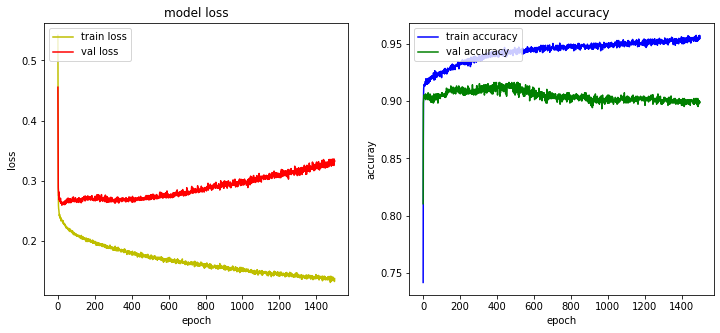

Test Accuracy = 0.9074627161026001


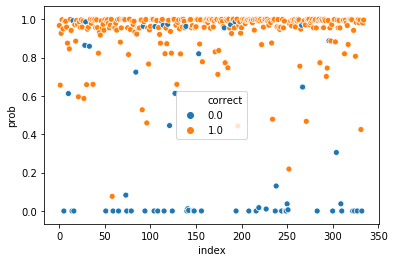

In [88]:
visual_training(hist)
visual_model_performance(loss_and_accuracy, pred_and_label)